# Cat and Dog image recognition. 
#### Introduction
In this notebook I produce an image classification model to decide if the image is of that of a cat or a dog.

### Importing the Libraries and downloading the data

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip
 
!unzip cats_and_dogs.zip
 
PATH = 'cats_and_dogs'
 
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')
 
# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)]) # r is roots, d is directories and files is files like (text.txt, dog.jpg, etc.)
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)]) # we are finding the number of files wherever we find them while traversing the loop
total_test = len(os.listdir(test_dir))
 
# Variables for pre-processing and training.

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
batch_size = 128
epochs = 20
IMG_HEIGHT = 150
IMG_WIDTH = 150

### Creating the dataset and standarizing it.
RGB channel is between 1 and 255. For neural networks we need it to be between 0 and 1. So we create and image generator that rescales the image when applied.

In [4]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
)
 
validation_image_generator = ImageDataGenerator(
        rescale=1./255,
        )
 
test_image_generator = ImageDataGenerator(
    rescale=1./255
)
 
train_data_gen = train_image_generator.flow_from_directory(
        train_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary')
 
val_data_gen = validation_image_generator.flow_from_directory(
        validation_dir,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        shuffle=True,
        class_mode='binary')
 
test_data_gen = test_image_generator.flow_from_directory(
        PATH,
        classes=['test'], 
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [5]:
test_data_gen.image_shape

(150, 150, 3)

#### Creating Image generators.
Plot images is used to print the images below. Here I print 5 randam images to inspect.

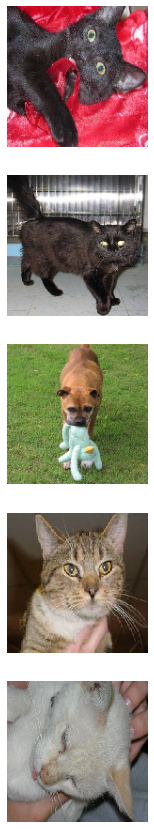

In [6]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()
 
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])

There is a small number of images. To prevent overfitting, an image generator is created. This image generator takes a single image and return many more by appling random transforation to it. Such as flipping it.

In [7]:
train_image_generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        featurewise_center=True,
        rotation_range=20)

Here is the train image generator being used on a single image.

Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


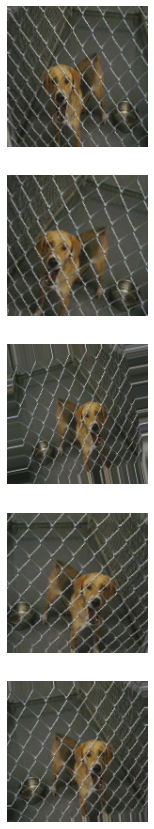

In [8]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')
 
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
 
plotImages(augmented_images)

### Building the Model. 
A model is built below that will be used to predict the images. It includes a stack of Conv2D and MaxPooling2d layers. A final softmax layer decides whether the image is that of a dog or a cat.

In [9]:
conv_base = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')

80150528/80134624 [==============================] - 2s 0us/step


In [10]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
for layers in conv_base.layers:
  layers.trainable=False

In [12]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1048704   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 21,081,409
Trainable params: 1,057,025
Non-trainable params: 20,024,384
_________________________________________________________________


### Traing the model
The model is trained

In [13]:
history = model.fit(train_data_gen, epochs=epochs,
                    steps_per_epoch=int(np.ceil(total_train / float(batch_size))), 
                    validation_data=val_data_gen,
                    validation_steps=int(np.ceil(total_val / float(batch_size)))
                    )

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
16/16 [==============================] - 90s 3s/step - loss: 0.6384 - accuracy: 0.6605 - val_loss: 0.4080 - val_accuracy: 0.8150
Epoch 2/20
16/16 [==============================] - 23s 1s/step - loss: 0.4051 - accuracy: 0.8225 - val_loss: 0.3458 - val_accuracy: 0.8560
Epoch 3/20
16/16 [==============================] - 23s 1s/step - loss: 0.3328 - accuracy: 0.8520 - val_loss: 0.3229 - val_accuracy: 0.8690
Epoch 4/20
16/16 [==============================] - 23s 1s/step - loss: 0.2996 - accuracy: 0.8765 - val_loss: 0.2786 - val_accuracy: 0.8790
Epoch 5/20
16/16 [==============================] - 23s 1s/step - loss: 0.2820 - accuracy: 0.8770 - val_loss: 0.2656 - val_accuracy: 0.8900
Epoch 6/20
16/16 [==============================] - 23s 1s/step - loss: 0.2542 - accuracy: 0.9025 - val_loss: 0.2583 - val_accuracy: 0.8850
Epoch 7/20
16/16 [==============================] - 23s 1s/step - loss: 0.2529 - accuracy: 0.8930 - val_loss: 0.2531 - val_accuracy: 0.8920
Epoch 8/20
16/16 [==

Visualizing the accuracy and loss of the model.

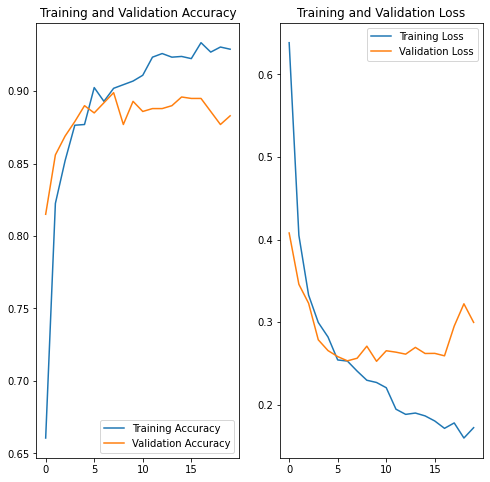

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs_range = range(epochs)
 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Using the Model to predict whether the test images are images of cats or dogs.

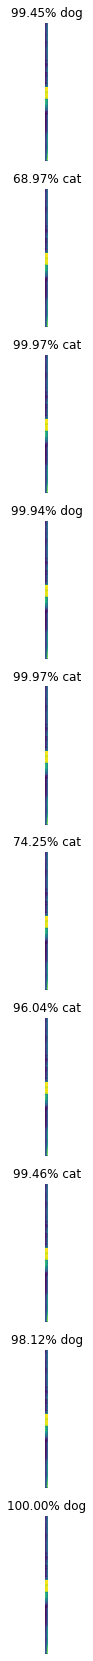

In [15]:
probabilities = model.predict(test_data_gen)
prediction = np.round(probabilities).astype(int)
images = [test_data_gen[0][0][0] for i in range(10)]
plotImages(images ,probabilities=probabilities)

In [16]:
print(probabilities)

[[9.9449676e-01]
 [3.1033152e-01]
 [2.5768584e-04]
 [9.9937880e-01]
 [3.3429961e-04]
 [2.5746709e-01]
 [3.9565634e-02]
 [5.3968062e-03]
 [9.8120248e-01]
 [9.9999332e-01]
 [2.3140834e-01]
 [9.9999917e-01]
 [7.9334140e-02]
 [9.9998963e-01]
 [7.3715240e-01]
 [9.9998283e-01]
 [9.3204963e-01]
 [3.3360115e-01]
 [9.8487258e-01]
 [9.9997115e-01]
 [4.4470304e-04]
 [9.8930186e-01]
 [9.9998844e-01]
 [9.7195476e-01]
 [9.9998951e-01]
 [9.9943417e-01]
 [9.9874240e-01]
 [3.6010821e-03]
 [1.7834374e-01]
 [1.9996169e-03]
 [6.8101205e-04]
 [4.0182490e-03]
 [7.8943449e-01]
 [9.9961960e-01]
 [9.9330181e-03]
 [9.9758971e-01]
 [9.9998808e-01]
 [9.9973196e-01]
 [9.9296725e-01]
 [1.7871897e-01]
 [1.7138068e-01]
 [3.0389547e-03]
 [9.9943262e-01]
 [9.9915111e-01]
 [1.1271477e-02]
 [2.0538700e-01]
 [3.1615323e-01]
 [1.7754390e-04]
 [3.4928448e-02]
 [3.5526070e-03]]


In [17]:
x = probabilities
x = np.reshape(x, 50)

In [18]:
x = ['{:f}'.format(item) for item in x]
print(x)

['0.994497', '0.310332', '0.000258', '0.999379', '0.000334', '0.257467', '0.039566', '0.005397', '0.981202', '0.999993', '0.231408', '0.999999', '0.079334', '0.999990', '0.737152', '0.999983', '0.932050', '0.333601', '0.984873', '0.999971', '0.000445', '0.989302', '0.999988', '0.971955', '0.999990', '0.999434', '0.998742', '0.003601', '0.178344', '0.002000', '0.000681', '0.004018', '0.789434', '0.999620', '0.009933', '0.997590', '0.999988', '0.999732', '0.992967', '0.178719', '0.171381', '0.003039', '0.999433', '0.999151', '0.011271', '0.205387', '0.316153', '0.000178', '0.034928', '0.003553']


In [19]:
from matplotlib import image
from matplotlib import pyplot


In [20]:
import cv2

uint8
(499, 381, 3)


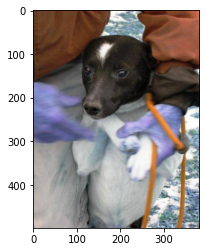

array([[1.]], dtype=float32)

In [21]:
img = cv2.imread('/content/cats_and_dogs/test/1.jpg')

print(img.dtype)
print(img.shape)
pyplot.imshow(img)
pyplot.show()

img = cv2.resize(img, (150, 150))
img = np.array(img, dtype="float32")
img = np.reshape(img, (1, 150, 150, 3))

model.predict(img)

uint8
(370, 278, 3)


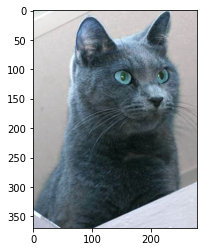

array([[0.]], dtype=float32)

In [22]:
img = cv2.imread('/content/cats_and_dogs/test/11.jpg')

print(img.dtype)
print(img.shape)
pyplot.imshow(img)
pyplot.show()

img = cv2.resize(img, (150, 150))
img = np.array(img, dtype="float32")
img = np.reshape(img, (1, 150, 150, 3))

model.predict(img)


## 1 is dog
## 0 is cat

Testing to seee how good the model is

In [23]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]
 
correct = 0
 
for probability, answer in zip(prediction, answers):
  if probability == answer:
    correct +=1
 
percentage_identified = (correct / len(answers))*100
 
passed_challenge = percentage_identified > 0.63
 
print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")
 
if passed_challenge:
  print("The model has passed testing.")
else:
  print("The Model is not accuarate enough.")

Your model correctly identified 94.0% of the images of cats and dogs.
The model has passed testing.


In [24]:
model.save('Cat&Dog.h5')

## Converting the Model

In [25]:
# Converting the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpew7jq4rd/assets


In [26]:
# Saving the model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


In [27]:
interpreter = tf.lite.Interpreter(model_path = '/content/model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 150 150   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 1]
Output Type: <class 'numpy.float32'>
